In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import seaborn as sns

resultado_anterior = 0

In [2]:
def modelfit(model, features, labels, usarCrossValidation=True, cv_folds=5, early_stopping_rounds=50):
    if usarCrossValidation:
        parametros = model.get_xgb_params()
        dmatrix = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(parametros, dmatrix, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=True, early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
    
    model.fit(features, labels,eval_metric='auc')
    
def obtener_marca(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(prefix + modelo.split()[0])
    return r

### Lectura csv

In [3]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

### Creacion de features

In [4]:
#
###                               CREACION DF PREDICTOR
#

dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#
###                               FILTRADO DE FECHAS
#

antesDeMayo = df.loc[df['timestamp'] < pd.to_datetime('01-05-2018')]
ult30Dias = df.loc[(df['timestamp'] > pd.to_datetime('01-05-2018'))]# & (df['timestamp'] > pd.to_datetime('15-05-2018'))]
ult15Dias = df.loc[(df['timestamp'] > pd.to_datetime('15-05-2018'))]# & (df['timestamp'] > pd.to_datetime('25-05-2018'))]
ult5Dias = df.loc[(df['timestamp'] > pd.to_datetime('25-05-2018'))]# & (df['timestamp'] > pd.to_datetime('31-05-2018'))]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]

#
###                               CREACION DE FEATURES
#

#
##  POR EVENTO


#  CHECKOUTS

checkoutsPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaAntesDeMayo.columns = ['checkoutsPorPersonaAntesDeMayo']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']


dfPredictor = dfPredictor.join(checkoutsPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  CONVERSIONES

conversionesPorPersonaAntesDeMayo = antesDeMayo.loc[antesDeMayo['event'] == 'checkout']['person'].value_counts().to_frame()
conversionesPorPersonaAntesDeMayo.columns = ['conversionesPorPersonaAntesDeMayo']

conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

dfPredictor = dfPredictor.join(conversionesPorPersonaAntesDeMayo, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  VISITAS

visitasUlt15DiasPorPersona = ult15Dias.loc[ult15Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt15DiasPorPersona.columns = ['CantVisitasUlt15Dias']

visitasUlt5DiasPorPersona = ult5Dias.loc[ult5Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt5DiasPorPersona.columns = ['CantVisitasUlt5Dias']

visitasUltDiaPorPersona = ultDia.loc[ultDia['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUltDiaPorPersona.columns = ['CantVisitasUltDia']

dfPredictor = dfPredictor.join(visitasUlt15DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUlt5DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUltDiaPorPersona, how = 'left', on = 'person').fillna(value = 0)


#  VIEWED PRODUCT

viewedProductPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt15Dias.columns = ['viewedProductUlt15Dias']

viewedProductPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt5Dias.columns = ['viewedProductUlt5Dias']

viewedProductPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUltDia.columns = ['viewedProductUltDia']

dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### POR CANAL DE ORIGEN

visitasUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'visited site']
visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

#  PAGO

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)


#  ORGANIC

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)


#  DIRECT
directUlt30Dias = visitasUlt30Dias.loc[visitasUlt30Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt30Dias.columns = ['CanalDirectoUlt30Dias']

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']
#directUlt15Dias['CanalDirectoUlt15Dias'] = 1

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

dfPredictor = dfPredictor.join(directUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)


#  REFERRAL

referralUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt15Dias.columns = ['CanalReferidoUlt15Dias']

referralUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt5Dias.columns = ['CanalReferidoUlt5Dias']

referralUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUltDia.columns = ['CanalReferidoUltDia']

dfPredictor = dfPredictor.join(referralUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUltDia, how = 'left', on = 'person').fillna(value = 0)


#  SOCIAL

socialUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt15Dias.columns = ['CanalSocialUlt15Dias']

socialUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt5Dias.columns = ['CanalSocialUlt5Dias']

socialUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Social']['person'].value_counts().to_frame()
socialUltDia.columns = ['CanalSocialUltDia']

dfPredictor = dfPredictor.join(socialUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUltDia, how = 'left', on = 'person').fillna(value = 0)


#  EMAIL

emailUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt15Dias.columns = ['CanalEmailUlt15Dias']

emailUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt5Dias.columns = ['CanalEmailUlt5Dias']

emailUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Email']['person'].value_counts().to_frame()
emailUltDia.columns = ['CanalEmailUltDia']

dfPredictor = dfPredictor.join(emailUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### FEATURES AVANZADOS

#  CANTIDAD DE CHECKOUTS POR MARCA

#marcas = {'Samsung':'Samsung', 'Motorola':'Motorola', 'iPhone':'iPhone', 'LG':'LG', 'Sony':'Sony', 'Lenovo':'Lenovo','iPad':'iPad', 'Quantum':'Quantum', 'Asus':'Asus'}
prefijo = "total_checks_"
#marcas = {marca: prefijo + nombreFeature for marca, nombreFeature in marcas.items()}

total_checks = df.loc[df["event"]=="checkout"].copy()
total_checks["Marca"] = obtener_marca(total_checks["model"],prefijo)
#total_checks = total_checks.loc[(total_checks["Marca"]==marcas["iPhone"])|(total_checks["Marca"]==marcas["Samsung"])]
total_checks["contador"] = 1
total_checks=total_checks.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_checks, how = 'left', on = 'person').fillna(value = 0)

prefijo = "total_views_"
total_views = ult30Dias.loc[ult30Dias["event"]=="viewed product"].copy()
total_views["Marca"] = obtener_marca(total_views["model"],prefijo)
#total_views = total_views.loc[(total_views["Marca"]==marcas["iPhone"])|(total_views["Marca"]==marcas["Samsung"])]
total_views["contador"] = 1
total_views=total_views.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_views, how = 'left', on = 'person').fillna(value = 0)

## CANTIDAD DE BUSQUEADAS
name_feature1 = "cant_searchs_ult_30"
name_feature2 = "busco_ult_30"
cant_search = ult30Dias.loc[ult30Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_15"
name_feature2 = "busco_ult_15"
cant_search = ult15Dias.loc[ult15Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_ult_5"
name_feature2 = "busco_ult_5"
cant_search = ult5Dias.loc[ult5Dias["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

name_feature1 = "cant_searchs_total"
name_feature2 = "busco_total"
cant_search = df.loc[df["event"]== "searched products",["person","search_term"]]
cant_search = cant_search[pd.notnull(cant_search['search_term'])]
cant_search[name_feature1] = 1
cant_search = cant_search.groupby("person").agg("sum")
cant_search[name_feature2] = [bool(x) for x in cant_search[name_feature1]]
dfPredictor = dfPredictor.join(cant_search, how = 'left', on = 'person')
dfPredictor[name_feature1].fillna(value = 0,inplace=True)
dfPredictor[name_feature2].fillna(value = False,inplace=True)

# Primer ingreso
tiempo_prom = df.loc[(df['event']!='ad campaign hit') & (df['event']!='search engine hit'),["person","timestamp"]]
tiempo_prom = tiempo_prom.groupby("person").agg({"timestamp":"min"})
tiempo_prom["first"] = (pd.to_datetime("2018-06-01")-tiempo_prom["timestamp"]).dt.days
del tiempo_prom['timestamp']
tiempo_prom
dfPredictor = dfPredictor.join(tiempo_prom, how = 'left', on = 'person')
dfPredictor["first"].fillna(value = 180,inplace=True)

# region desde donde mas visita
region = df.loc[(df["event"] == "visited site") & (df['country'] == 'Brazil'), ['person','region']]
region = region
region["count"] =1
region = region.groupby(["person","region"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del region["count"]
region.set_index("person",inplace=True)
regionesNoBrasil = df.loc[(df["event"] == "visited site") & (df['country'] != 'Brazil')]['region'].unique()
region['region'].cat.remove_categories(regionesNoBrasil,inplace=True)
region = pd.get_dummies(region['region'])
dfPredictor = dfPredictor.join(region, how = 'left', on = 'person').fillna(value = 0)


# Pais
pais = df.loc[df["event"] == "visited site", ['person','country']]
pais["count"] =1
pais = pais.groupby(["person","country"]).agg({"count":"count"}).reset_index()\
    .sort_values('count', ascending=False).drop_duplicates("person")
del pais["count"]
pais["esDeBrasil"] = pais["country"] == "Brazil"
del pais["country"]
pais.set_index("person",inplace=True)
dfPredictor = dfPredictor.join(pais, how = 'left', on = 'person')
dfPredictor["esDeBrasil"].fillna(value = False,inplace=True)

#vieron
vieron_celular = df.loc[(df["event"] == "viewed product") & (df["model"] == "Samsung Galaxy J5"),["person"]]
vieron_celular["vieron_celular"] = 1
vieron_celular.set_index("person",inplace=True)
vieron_celular = vieron_celular[~vieron_celular.index.duplicated(keep='first')]
dfPredictor = dfPredictor.join(vieron_celular, how = 'left', on = 'person')
dfPredictor["vieron_celular"].fillna(value = 0,inplace=True)

### TEEEEEEEEEEST Cuantas veces hizo checkout de los 20 celus mas visitados
view_products = ult15Dias.loc[ult15Dias["event"] == "checkout",["model"]].copy()
view_products["Visitas"] = 1
phones20view = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(4).index.tolist()
checkouts = df.loc[df["event"]=="checkout",["person","model"]].copy()
def estaDentroDe(serie,lista):
    r = []
    for i in serie:
        if i in lista:
            r.append(True)
        else:
            r.append(False)
    return r
checkouts["model"] = estaDentroDe(checkouts["model"],phones20view)
checkouts= checkouts.groupby("person").agg("sum")
dfPredictor = dfPredictor.join(checkouts, how = 'left', on = 'person')
dfPredictor["model"].fillna(value = 0,inplace=True)


### Agregado y quitado de features y cambio de disposicion de las columnas

In [5]:
print(str(dfPredictor.columns))

Index(['checkoutsPorPersonaAntesDeMayo', 'checkoutsUlt30Dias',
       'checkoutsUlt15Dias', 'checkoutsUlt5Dias', 'checkoutsUltDia',
       'conversionesPorPersonaAntesDeMayo', 'conversionesUlt30Dias',
       'conversionesUlt15Dias', 'conversionesUlt5Dias', 'conversionesUltDia',
       'CantVisitasUlt15Dias', 'CantVisitasUlt5Dias', 'CantVisitasUltDia',
       'viewedProductUlt15Dias', 'viewedProductUlt5Dias',
       'viewedProductUltDia', 'CanalPagoUlt15Dias', 'CanalPagoUlt5Dias',
       'CanalPagoUltDia', 'CanalOrganicoUlt15Dias', 'CanalOrganicoUlt5Dias',
       'CanalOrganicoUltDia', 'CanalDirectoUlt30Dias', 'CanalDirectoUlt15Dias',
       'CanalDirectoUlt5Dias', 'CanalDirectoUltDia', 'CanalReferidoUlt15Dias',
       'CanalReferidoUlt5Dias', 'CanalReferidoUltDia', 'CanalSocialUlt15Dias',
       'CanalSocialUlt5Dias', 'CanalSocialUltDia', 'CanalEmailUlt15Dias',
       'CanalEmailUlt5Dias', 'CanalEmailUltDia', 'total_checks_Asus',
       'total_checks_LG', 'total_checks_Lenovo', 'total_

In [6]:
# Cambio disposicion de columnas ya que esta presenta mejor resultado
# Cuando se agregue una feature nueva, agregar el nombre de columna a esta lista para que surta efecto
# Reordenar en la lista cambia el orden de las columnas en el predictor

cols = [
'CanalDirectoUlt15Dias',
'checkoutsUlt15Dias',
'checkoutsUlt30Dias',
'checkoutsUlt5Dias',
'checkoutsUltDia',
'conversionesUlt30Dias',
'conversionesUlt15Dias',
'conversionesUlt5Dias',
'conversionesUltDia',
'CantVisitasUlt15Dias',
'CantVisitasUlt5Dias',
'CantVisitasUltDia',
'viewedProductUlt15Dias',
'viewedProductUlt5Dias',
'viewedProductUltDia',
'CanalOrganicoUlt5Dias',
'CanalDirectoUlt5Dias',
'CanalDirectoUltDia',
'CanalReferidoUlt15Dias',
'CanalReferidoUlt5Dias',
'CanalReferidoUltDia',
'total_checks_Samsung',
'total_checks_iPhone',
'cant_searchs_ult_15',
#'CanalPagoUlt5Dias',
#'total_views_Samsung',
#'total_views_iPhone',
#'total_checks_Motorola',
#'total_views_Motorola',
#'CanalDirectoUlt30Dias'
#'total_views_Asus',
#'total_views_LG',
#'total_views_Lenovo',
#'total_views_Quantum',
#'total_views_Sony',
#'total_views_iPad',
#'total_checks_Asus',
#'total_checks_LG',
#'total_checks_Lenovo',
#'total_checks_Quantum',
#'total_checks_Sony',
#'checkoutsPorPersonaAntesDeMayo',
#'conversionesPorPersonaAntesDeMayo',
#'CanalPagoUlt15Dias',
#'CanalPagoUltDia',
#'CanalOrganicoUlt15Dias',
#'CanalOrganicoUltDia',
#'CanalSocialUlt15Dias',
#'CanalSocialUlt5Dias',
#'CanalSocialUltDia',
#'CanalEmailUlt15Dias',
#'CanalEmailUlt5Dias',
#'CanalEmailUltDia',
#"first" 
#'cant_searchs_ult_30',
#'busco_ult_30',
#'busco_ult_15',
#'cant_searchs_ult_5',
#'busco_ult_5', 
#'cant_searchs_total',
#"busco_total"
#"region",
#'esDeBrasil',
##"vieron_celular",
#'Acre', 'Alagoas', 'Amapa', 'Amazonas', 'Bahia',
#'Ceara', 'Espirito Santo', 'Federal District', 'Goias', 'Maranhao',
#'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Para', 'Parana',
#'Paraíba', 'Pernambuco', 'Piaui', 'Rio Grande do Norte',
#'Rio Grande do Sul', 'Rio de Janeiro', 'Rondonia', 'Roraima',
#'Santa Catarina', 'Sao Paulo', 'Sergipe', 'Tocantins'
]


# Separo los labels locales
dfPredictorIndexado=dfPredictor.reindex(columns=cols)
#dfPredictorIndexado = dfPredictorIndexado.join(one_hot, how = 'left', on = 'person')
dfPredictorLocal = dfPredictorIndexado.join(labels, how = 'inner')

### Entrenamiento del modelo

In [7]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

modelo = xgb.XGBRegressor(
 #booster='dart',
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.4,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=-1,
 #sample_type='weighted',
 #rate_drop=0.05,
 #skip_dropout=0.3,
 random_state=27)

modelfit(modelo, X_train, y_train, early_stopping_rounds=50)

predsa = modelo.predict(X_test)
resultado = roc_auc_score(y_test, predsa)
print(resultado)

print("Vario: {} con respecto al anterior".format(resultado-resultado_anterior))
resultado_anterior = resultado

[0]	train-auc:0.80856+0.0125284	test-auc:0.800472+0.023754
[1]	train-auc:0.826662+0.0113302	test-auc:0.817998+0.0226381
[2]	train-auc:0.839848+0.0094987	test-auc:0.830697+0.0186583
[3]	train-auc:0.847207+0.00531615	test-auc:0.835517+0.0197123
[4]	train-auc:0.851106+0.0074112	test-auc:0.840795+0.0133221
[5]	train-auc:0.851312+0.00747508	test-auc:0.841023+0.0136258
[6]	train-auc:0.852578+0.00730564	test-auc:0.842397+0.0144838
[7]	train-auc:0.856332+0.00751917	test-auc:0.846078+0.014016
[8]	train-auc:0.858357+0.00780646	test-auc:0.846871+0.0141608
[9]	train-auc:0.858655+0.00751471	test-auc:0.847263+0.0144597
[10]	train-auc:0.861002+0.00865968	test-auc:0.848161+0.0135959
[11]	train-auc:0.861696+0.00908017	test-auc:0.848862+0.0121635
[12]	train-auc:0.86277+0.0088578	test-auc:0.850056+0.012872
[13]	train-auc:0.864175+0.00783726	test-auc:0.852165+0.0136019
[14]	train-auc:0.864669+0.00776031	test-auc:0.852078+0.0139024
[15]	train-auc:0.864804+0.00773756	test-auc:0.852697+0.0143621
[16]	train-a

[131]	train-auc:0.885721+0.00329957	test-auc:0.863785+0.0124994
[132]	train-auc:0.885861+0.00322822	test-auc:0.863746+0.0125008
[133]	train-auc:0.885966+0.00328394	test-auc:0.863674+0.0123427
[134]	train-auc:0.886079+0.00323645	test-auc:0.863768+0.012448
[135]	train-auc:0.886166+0.0032304	test-auc:0.863686+0.012629
[136]	train-auc:0.886205+0.00321233	test-auc:0.863626+0.0125236
[137]	train-auc:0.886291+0.00309896	test-auc:0.863855+0.0126343
[138]	train-auc:0.88647+0.00316353	test-auc:0.863839+0.0127224
[139]	train-auc:0.886575+0.0031772	test-auc:0.863854+0.0127748
[140]	train-auc:0.886634+0.003199	test-auc:0.863937+0.0128659
[141]	train-auc:0.886562+0.00299603	test-auc:0.863962+0.0130182
[142]	train-auc:0.886641+0.00294052	test-auc:0.863969+0.0131616
[143]	train-auc:0.886798+0.00299806	test-auc:0.863875+0.0131681
[144]	train-auc:0.886847+0.00297917	test-auc:0.864087+0.0132901
[145]	train-auc:0.886937+0.00306886	test-auc:0.864203+0.0131357
[146]	train-auc:0.88704+0.00305267	test-auc:0.8

### Creacion del submit para kaggle

In [8]:
modelfit(modelo, X, y, early_stopping_rounds=50)
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictorIndexado.join(kaggle, how = 'inner')
predsSubmit = modelo.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

[0]	train-auc:0.815976+0.0146163	test-auc:0.810829+0.0211485
[1]	train-auc:0.82836+0.010905	test-auc:0.821269+0.00975778
[2]	train-auc:0.834037+0.0108633	test-auc:0.825812+0.012635
[3]	train-auc:0.842693+0.00580262	test-auc:0.831922+0.0130688
[4]	train-auc:0.844667+0.00531373	test-auc:0.833524+0.0122828
[5]	train-auc:0.847611+0.00565491	test-auc:0.838163+0.0140032
[6]	train-auc:0.852423+0.00341168	test-auc:0.844591+0.013595
[7]	train-auc:0.853701+0.00417917	test-auc:0.8455+0.0124337
[8]	train-auc:0.854625+0.00382928	test-auc:0.846301+0.0128081
[9]	train-auc:0.856565+0.00550749	test-auc:0.848283+0.0100587
[10]	train-auc:0.85861+0.00536795	test-auc:0.852073+0.00633585
[11]	train-auc:0.858957+0.00524821	test-auc:0.852+0.00643732
[12]	train-auc:0.85931+0.004988	test-auc:0.851825+0.00712194
[13]	train-auc:0.860199+0.00515559	test-auc:0.853109+0.00797072
[14]	train-auc:0.861236+0.00480594	test-auc:0.85304+0.00769185
[15]	train-auc:0.862076+0.00461445	test-auc:0.852316+0.00774964
[16]	train-a

### Random forest para feature importance

<Figure size 720x720 with 0 Axes>

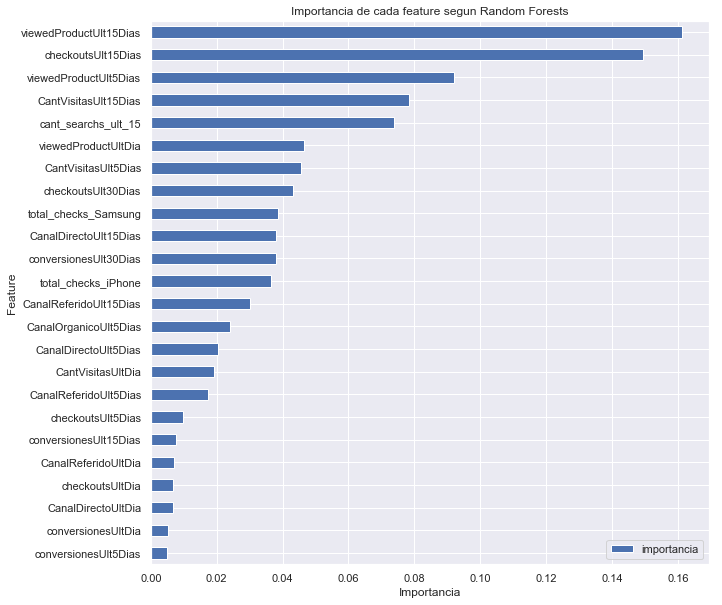

<Figure size 720x720 with 0 Axes>

In [9]:
from sklearn.ensemble import RandomForestRegressor

sns.set(rc={'figure.figsize':(10,10)})
names = X.columns
rf = RandomForestRegressor(
    random_state=123,
    n_estimators=400,
    min_samples_split=3
)
rf.fit(X_train.values, y_train.values.ravel())
impor = np.vstack((names, rf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False).iloc[::-1]
ax = imporDf.plot(kind='barh')
ax.set_title("Importancia de cada feature segun Random Forests")
ax.set(xlabel="Importancia", ylabel="Feature")
plt.figure(figsize=(10,10))
